# Model selection notebook

In [4]:
## Data import
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

## Read data and drop nan's
df_full = pd.read_excel('dataset.xls')
df_full.FlightNumber = df_full.FlightNumber.astype(object)
# df_full.SeatCapacity = df_full.SeatCapacity.astype(object)
df = df_full.dropna()
df = df.loc[df['FlightType'].isin(['C', 'J'])]

## Split time into usable data
df['Year'] = df.ScheduleTime.dt.year.astype(object);
df['Month'] = df['ScheduleTime'].dt.month.astype(object);
df['WeekNumber'] = df['ScheduleTime'].dt.isocalendar().week % 52;
df['Weekday'] = df['ScheduleTime'].dt.dayofweek;
df.WeekNumber = df.WeekNumber.astype(object);
df.Weekday = df.Weekday.astype(object);
df['HourOfDay'] = df['ScheduleTime'].dt.hour.astype(object);
df['MinuteOfHour'] = df['ScheduleTime'].dt.minute.astype(object);

## Define feature columns
feature_cols = ['Airline', 'FlightNumber', 'Destination', 'AircraftType', 'FlightType', 'Sector', 'SeatCapacity', 'Year', 'Month', 'WeekNumber', 'Weekday', 'HourOfDay', 'MinuteOfHour']
under_15_cols = ['FlightType', 'Sector', 'Year', 'Month', 'Weekday', 'MinuteOfHour']
over_15_cols = ['Airline', 'FlightNumber', 'Destination', 'AircraftType', 'WeekNumber', 'HourOfDay']
nominal_cols = ['Airline', 'FlightNumber', 'Destination', 'AircraftType', 'FlightType', 'Sector', 'Year', 'Month', 'WeekNumber', 'Weekday', 'HourOfDay', 'MinuteOfHour']
ordinal_cols = ['SeatCapacity']

## Split target from feature data
X = df[feature_cols]
y = df['LoadFactor']

## Encode features with one-hot-encoding
# X = pd.get_dummies(data=X, columns=under_15_cols)
X = pd.get_dummies(data=X, columns=nominal_cols);
# warnings.filterwarnings('default')
X

,SeatCapacity,Airline_AY,Airline_BJ,Airline_BT,Airline_BZ,Airline_CL,Airline_CN,Airline_DO,Airline_DT,Airline_DU,...,MinuteOfHour_15,MinuteOfHour_20,MinuteOfHour_25,MinuteOfHour_30,MinuteOfHour_35,MinuteOfHour_40,MinuteOfHour_45,MinuteOfHour_50,MinuteOfHour_54,MinuteOfHour_55
0,142,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,74,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,142,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,72,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,186,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36765,180,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
36766,156,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
36767,156,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
36768,189,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Let's try some stuff

In [2]:
### Make train/val set 0.8 and test 0.2 sizes
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0);
# Xtemp, Xtest, ytemp, ytest = train_test_split(X, y, test_size=0.2, random_state=0);
# Xtrain, Xval, ytrain, yval = train_test_split(Xtemp, ytemp, test_size=0.25, random_state=0);

In [6]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

### Make functions for computing validation metric

def compute_cv_acc(X_cv, y_cv, model):
    Xtrain, Xval, ytrain, yval = train_test_split(X_cv, y_cv, test_size=0.25, random_state=0)
    model.fit(X=Xtrain, y=ytrain)
    train_pred = model.predict(X=Xtrain)
    val_pred = model.predict(X=Xval)
    train_mse = mean_squared_error(y_pred=train_pred, y_true=ytrain)
    print(f'Train MSE was: {train_mse}')
    val_mse = mean_squared_error(y_pred=val_pred, y_true=yval)

    return val_mse, model

# def k_fold_cv(X, y, model, k=10):

#     kf=KFold(n_splits=k, shuffle=True, random_state=0)

#     logs=[]
#     for train_index, test_index in kf.split(X):
#         X_train, X_test = X[:,train_index], X[:,test_index]
#         y_train, y_test = y[train_index], y[test_index]
#         model.fit(X_train, y_train)
#         y_pred = model.predict(X_test)
#         logs.append(mean_squared_error(y_test, y_pred))
#     return logs


## Linear models

In [11]:
from sklearn import linear_model
import numpy as np
import matplotlib.pyplot as plt

In [5]:
### Linear Regression
linreg_model = linear_model.LinearRegression()
linreg_val_mse, linreg_trained_model = compute_cv_acc(X_cv=X_train, y_cv=y_train, model=linreg_model)

print(f'Linear Regresion MSE: {linreg_val_mse}')

Train MSE was. 0.027036859794064737
Linear Regresion MSE: 498246372065306.44


alpha = 0.02040816326530612
Train MSE was: 0.027044562666490905
alpha = 0.04081632653061224
Train MSE was: 0.027053068930454387
alpha = 0.061224489795918366
Train MSE was: 0.027061446231966914
alpha = 0.08163265306122448
Train MSE was: 0.027069727247109838
alpha = 0.1020408163265306
Train MSE was: 0.02707791564806736
alpha = 0.12244897959183673
Train MSE was: 0.027086017856942687
alpha = 0.14285714285714285
Train MSE was: 0.027094043365946518
alpha = 0.16326530612244897
Train MSE was: 0.027102002250299007
alpha = 0.18367346938775508
Train MSE was: 0.027109903724770054
alpha = 0.2040816326530612
Train MSE was: 0.027117755596291936
alpha = 0.22448979591836732
Train MSE was: 0.02712556418841399
alpha = 0.24489795918367346
Train MSE was: 0.027133334471246228
alpha = 0.26530612244897955
Train MSE was: 0.027141070260959133
alpha = 0.2857142857142857
Train MSE was: 0.02714877442610457
alpha = 0.3061224489795918
Train MSE was: 0.02715644907489636
alpha = 0.32653061224489793
Train MSE was: 0.02

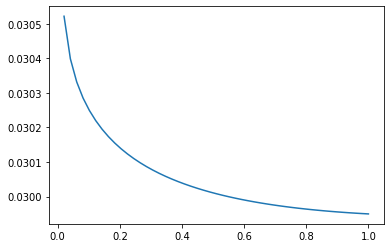

In [14]:
### Ridge Regression

ridge_mse = []
alphas = np.linspace(start=0, stop=1, num=50)[1:]
for i in alphas:
    print(f'alpha = {i}')
    ridge_model = linear_model.Ridge(alpha=float(i))
    ridge_val_mse, ridge_trained_model = compute_cv_acc(X_cv=X_train, y_cv=y_train, model=ridge_model)
    ridge_mse.append(ridge_val_mse)

plt.plot(alphas, ridge_mse)

# Tree Models

In [1]:
import xgboost as xgb


In [ ]:
Xtrain, Xval, ytrain, yval = train_test_split(X_cv, y_cv, test_size=0.25, random_state=0)